In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv']


In [39]:
df_train = pd.read_csv('../input/train.csv')
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

In [40]:
df_test = pd.read_csv('../input/test.csv')
df_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,0.635502,0.789497,-0.877764,-0.997766,-0.998414,-0.934345,-0.975669,-0.949824,-0.830478,-0.168084,-0.378996,0.246217,0.521204,-0.487793,0.482280,-0.045462,0.211955,-0.134894,0.130858,-0.014176,-0.105971,0.073544,-0.171516,0.040063,0.076989,-0.490546,-0.709003,...,-0.484619,-1.000000,-0.035356,-0.254248,-0.700326,-0.770610,-0.797113,-0.764485,-0.820188,-0.937959,-0.770610,-0.970958,-0.798387,0.179435,-1.000000,-0.047391,-0.467849,-0.761326,-0.890165,-0.907308,-0.895301,-0.917883,-0.909829,-0.890165,-0.994105,-0.898022,-0.234815,-1.000000,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,-0.554577,-0.806013,0.768031,0.683698,0.796706,-0.969097,-0.999580,-0.999646,-0.997720,-0.994006,-0.973637,-0.950720,-0.302437,-0.348243,-0.404785,0.507492,-0.156495,0.040674,0.272991,0.197566,-0.194556,0.411411,-0.340466,0.077555,-0.084024,0.035305,-0.010083,-0.104983,-0.429134,0.399177,...,-0.723642,-1.000000,-0.491213,-0.215404,-0.666004,-0.924461,-0.916774,-0.919383,-0.917983,-0.991121,-0.924461,-0.995727,-0.933127,-0.218860,-1.000000,-0.031474,-0.090655,-0.461801,-0.951977,-0.938212,-0.938008,-0.949922,-0.986902,-0.951977,-0.998272,-0.951255,-0.431053,-1.000000,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,-0.568512,-0.799116,0.848305,0.667864,0.822442,-0.976782,-0.999954,-0.999570,-0.998720,-0.993456,-0.974266,-0.964976,-0.617916,-0.695490,-0.536693,0.242147,-0.114997,0.032703,0.192385,-0.011945,-0.063363,0.470819,-0.507395,0.188536,-0.231575,0.632120,-0.550708,0.305653,-0.323848,0.279786,...,-0.898000,-1.000000,0.140729,-0.206062,-0.639809,-0.975209,-0.973998,-0.967097,-0.982849,-0.997663,-0.975209,-0.999504,-0.9682

In [41]:
df = pd.concat([df_train,df_test])
df.head()
df.shape

(10299, 563)

[Text(0,0,'LAYING'),
 Text(0,0,'STANDING'),
 Text(0,0,'SITTING'),
 Text(0,0,'WALKING'),
 Text(0,0,'WALKING_UPSTAIRS'),
 Text(0,0,'WALKING_DOWNSTAIRS')]

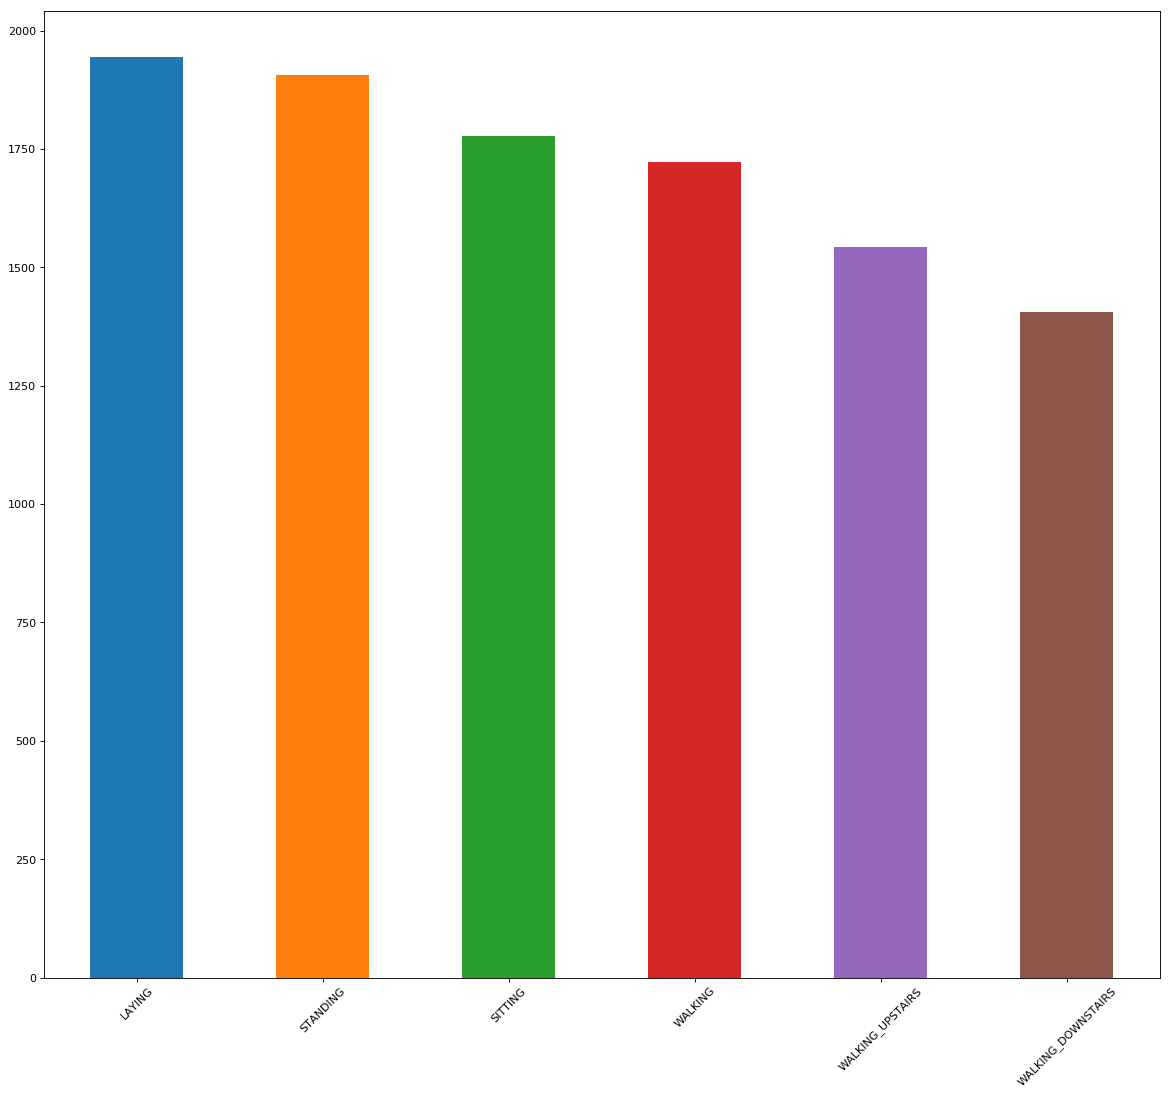

In [42]:
tsne_d = df.copy()
subject = tsne_d.pop('subject')
Activity_ = tsne_d.pop('Activity')
Activity_counts = Activity_.value_counts()

n = Activity_counts.shape[0]
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = Activity_counts.plot.bar()
ax.set_xticklabels(Activity_counts.index, rotation=45, fontsize=10)

In [43]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
sc = StandardScaler()
tsne_d = sc.fit_transform(tsne_d)

from sklearn.manifold import TSNE
tsne = TSNE()
tsne_transformed = tsne.fit_transform(tsne_d)

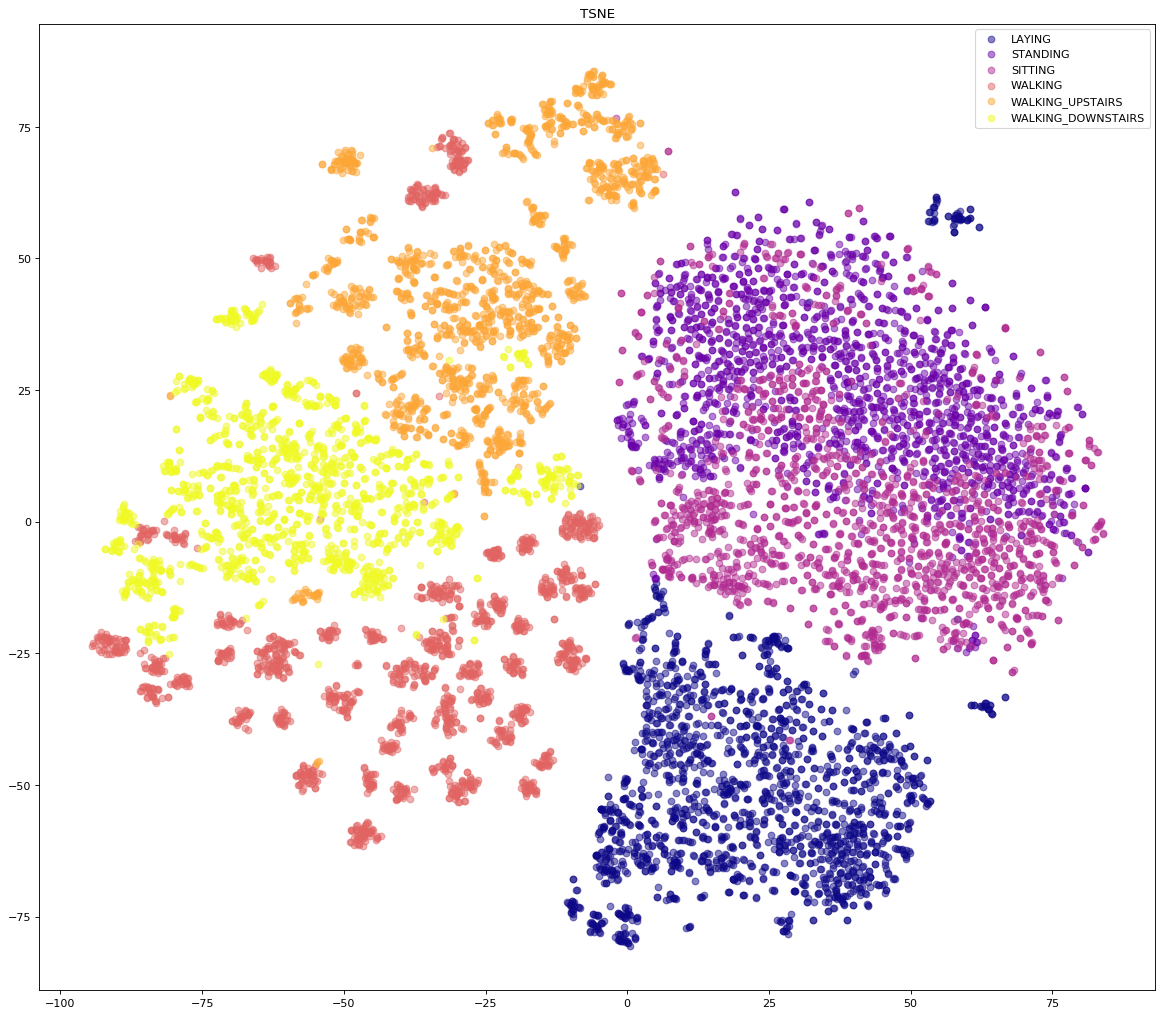

In [44]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
n = Activity_.unique().shape[0]
colormap = get_cmap('plasma')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

for i, group in enumerate(Activity_counts.index):
    mask = (Activity_==group).values
    plt.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
plt.title('TSNE')
plt.legend()
plt.show()

In [45]:
print(tsne_transformed.shape)
print(Activity_.shape)

(10299, 2)
(10299,)


[](http://)**Mostly the data is  separable (tSNE) is a bit of approximation so it will be safe to that the data is separable**

In [46]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tsne_transformed, Activity_, test_size = 0.30, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7209, 2)
(7209,)
(3090, 2)
(3090,)


In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score 

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0),
    KNeighborsClassifier(20),
    SVC(),
    GaussianNB(),
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(y_pred, y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores})
score_df

,Model,Score
0,DecisionTreeClassifier,0.949191
1,RandomForestClassifier,0.961489
2,KNeighborsClassifier,0.940453
3,SVC,0.958576
4,GaussianNB,0.856634


In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score SVC with rbf kernel :', accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
cm_svc = confusion_matrix(y_test, y_pred)

Accuracy score SVC with rbf kernel : 0.9585760517799353


In [49]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(20).fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy score KNN with k = 20 :",accuracy_score(y_pred, y_test))

cm_knn = confusion_matrix(y_test, y_pred)

y_test = np.array(y_test)

Accuracy score KNN with k = 20 : 0.940453074433657


Clearly standing and sitting are more miss classfied points

In [50]:
X_5_train = []
y_5_train = []
X_5_test = []
y_5_test = []

y_tr = y_train[:].tolist()
for i in range(len(X_train)):
    if y_tr[i] == "SITTING" or y_tr[i] == "STANDING":
        X_5_train.append(X_train[i])
        y_5_train.append(y_tr[i])

for i in range(len(X_test)):
    if y_test[i] == "SITTING" or y_test[i] == "STANDING":
        X_5_test.append(X_test[i])
        y_5_test.append(y_test[i])

In [51]:
clf1 = SVC().fit(X_5_train, y_5_train)
y_pred = clf1.predict(X_5_test)
print('Accuracy score:', accuracy_score(y_5_test, y_pred))


clf = KNeighborsClassifier(20).fit(X_5_train,y_5_train)
y_pred = clf.predict(X_5_test)
print(accuracy_score(y_pred, y_5_test))

Accuracy score: 0.9166666666666666
0.8570175438596491


Now combining the above to classifiers

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 

clf = KNeighborsClassifier(20).fit(X_train,y_train)
y_pred = clf.predict(X_test[0:])
y_pred = []
for i in range(X_test.shape[0]):
    temp = clf.predict([X_test[i]])
    if temp == "SITTING" or temp == "STANDING":
        temp = clf1.predict([X_test[i]])
    y_pred.append(temp)
from sklearn.metrics import confusion_matrix
cm_combined = confusion_matrix(y_test, y_pred)

print("Final accuracy by combining KNN and SVC - ",accuracy_score(y_pred, y_test))

Final accuracy by combining KNN and SVC -  0.9624595469255663


KNN accuracy -  ~94.3

SVC accuracy - ~95.9

Combining two we achieved - ~96.5

In [53]:
# print("SVC with 6 class\n\n",cm_svc,"\n")
# print("KNN with 6 class\n\n",cm_knn,"\n")
# print("Combined\n\n",cm_combined)
# print("Labels - ")
# print(sorted(Activity.unique()))

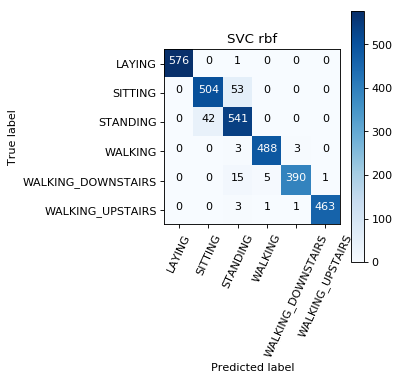

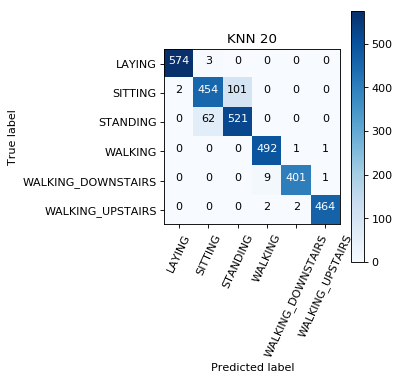

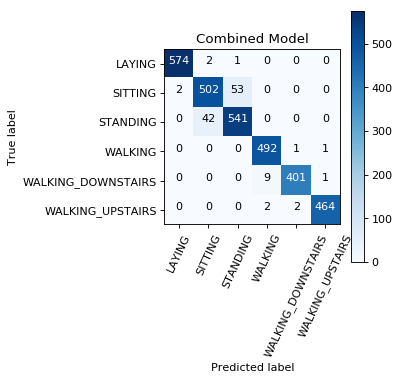

In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=65)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
Class_labels = sorted(Activity_.unique())
fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cm_svc, classes=Class_labels, title="SVC rbf")
fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cm_knn, classes=Class_labels, title="KNN 20")
fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cm_combined, classes=Class_labels, title="Combined Model")

plt.show()    

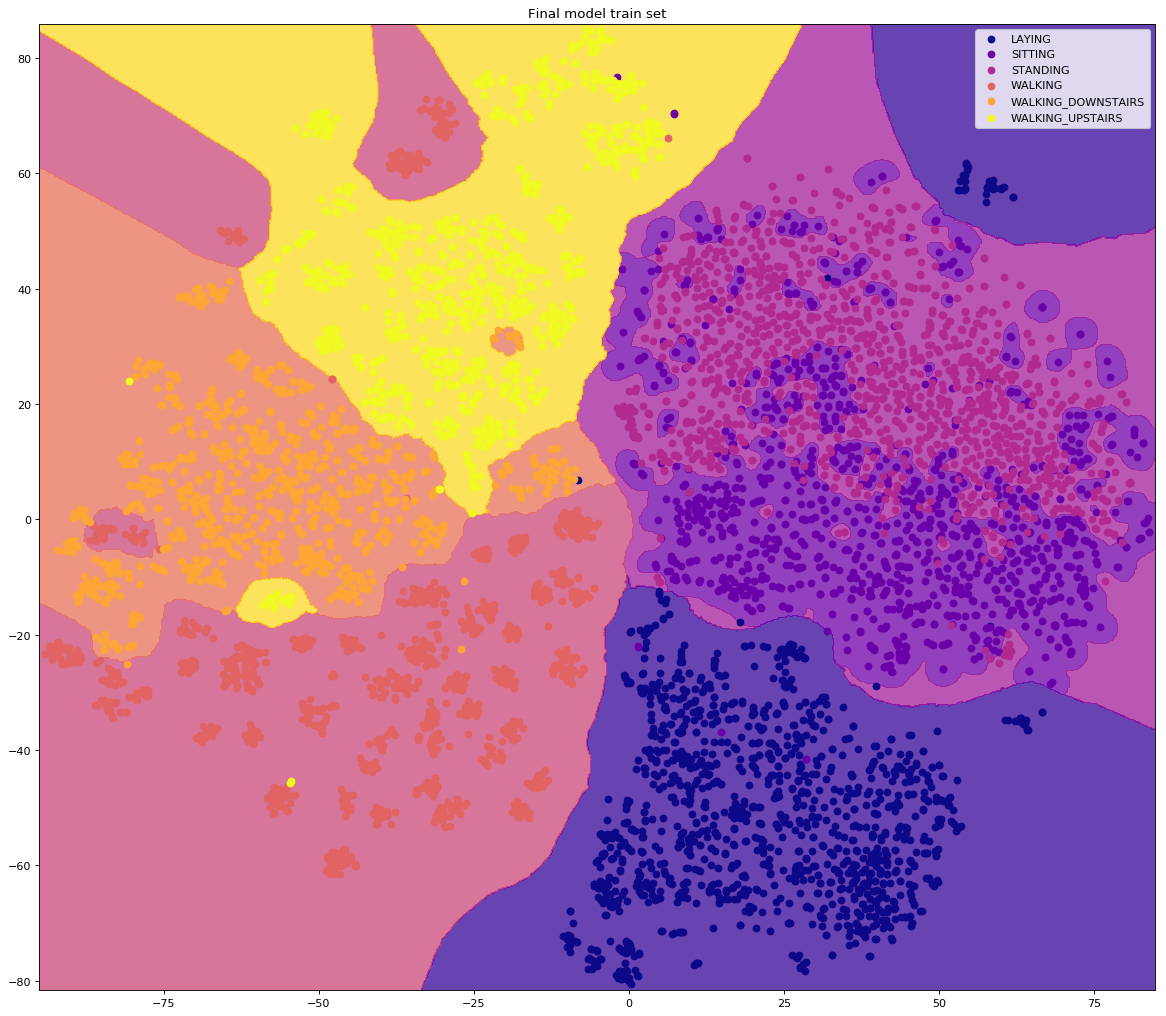

In [55]:
Activity = Activity_.values
# print(Activity)
# print(Class_labels)
y = np.zeros(len(Activity))
for i in range(len(Activity)):
    for j in range(len(Class_labels)):
        if Class_labels[j] == Activity[i]:
            y[i] = j
# print(y)
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(tsne_transformed, y, test_size = 0.30, random_state = 0)
# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)
clf = KNeighborsClassifier(20).fit(X_train,Y_train)
X_5_train = []
Y_5_train = []
X_5_test = []
Y_5_test = []

y_tr = Y_train[:].tolist()
for i in range(len(X_train)):
    if y_tr[i] == 1 or y_tr[i] == 2:
        X_5_train.append(X_train[i])
        Y_5_train.append(y_tr[i])

for i in range(len(X_test)):
    if Y_test[i] == 1 or Y_test[i] == 2:
        X_5_test.append(X_test[i])
        Y_5_test.append(Y_test[i])

clf1 = SVC().fit(X_5_train, Y_5_train)

# y_pred = clf1.predict(X_5_test)
def predict(X):
    y = clf.predict(X)
    for i in range(len(y)):
        if y[i] == 1 or y[i] == 2:
            y[i] = clf1.predict([X[i]])
    return y

from matplotlib.colors import ListedColormap
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
X_set, y_set = X_train, Y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.2),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.2))
x1 = X1.ravel()
x2 = X2.ravel()
y = predict(np.array ([x1, x2]).T)
plt.contourf(X1, X2, y.reshape(X1.shape),alpha = 0.75,cmap=get_cmap('plasma'))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],c = colors[i], label = Class_labels[int(j)])
plt.title('Final model train set')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

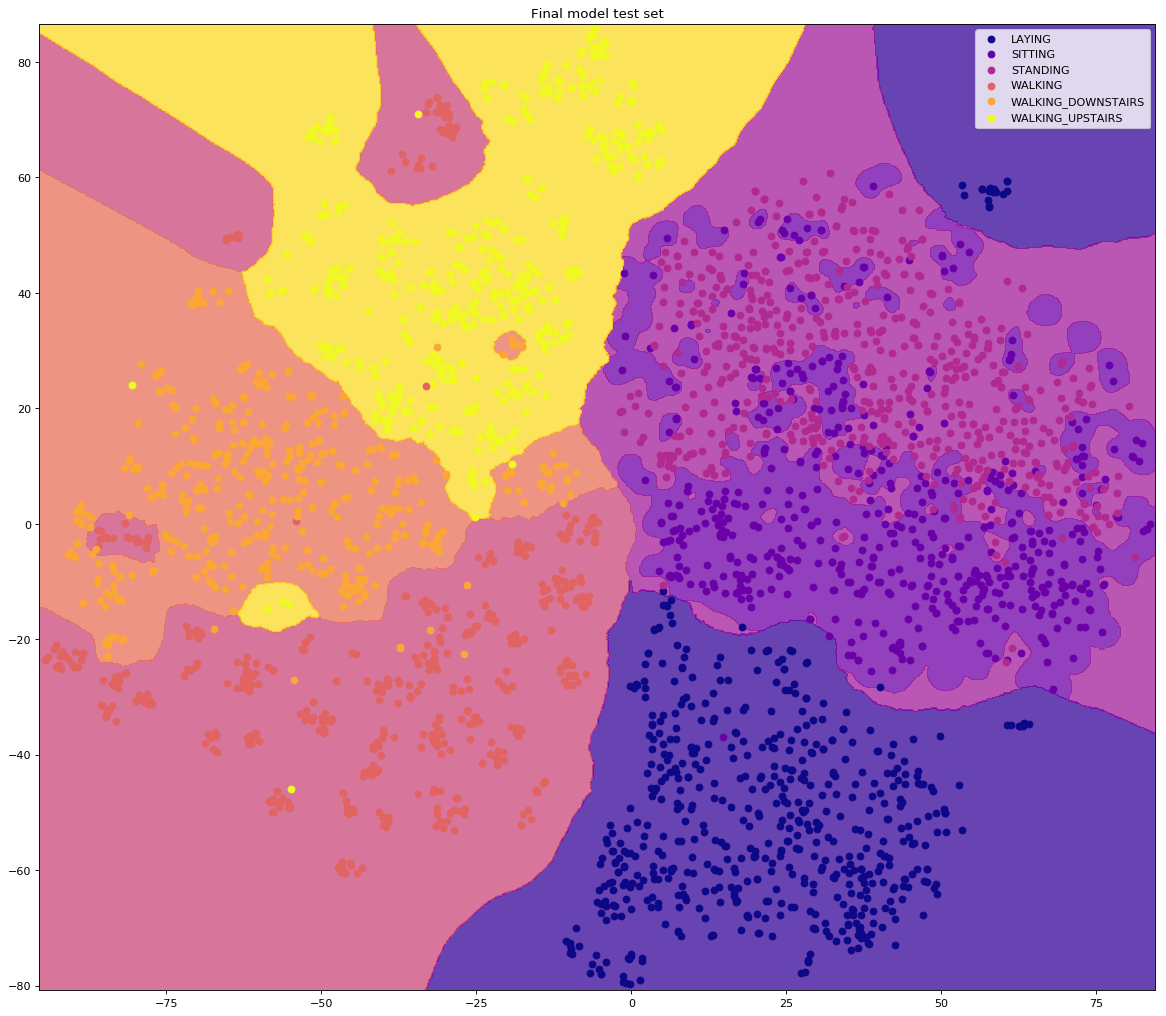

In [56]:
from matplotlib.colors import ListedColormap
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
X_set, y_set = X_test, Y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.2),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.2))
x1 = X1.ravel()
x2 = X2.ravel()
y = predict(np.array ([x1, x2]).T)
plt.contourf(X1, X2, y.reshape(X1.shape),alpha = 0.75,cmap=get_cmap('plasma'))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],c = colors[i], label = Class_labels[int(j)])
plt.title('Final model test set')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
plt.legend()
plt.show()